# GOLF timing

This is a toy notebook designed to compute the time lag between the GOLF and VIRGO/SPM instruments (both are aboard the SoHO satellite, see Domingo et al. 1995, Fröhlich et al. 1995, Gabriel et al. 1995).

In [1]:
import numpy as np
import apollinaire as apn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from os import path
from apollinaire.timing import compute_shift
import apollinaire.timeseries as timeseries
import importlib.resources
from tqdm import tqdm
%matplotlib widget
%matplotlib inline

Defining parameters for the cross-correlation operation:

In [2]:
#Defining parameters for the cross-correlation operation
sampling = 60 #GOLF and VIRGO series are sampled at 60s

#subseries of 10 days with an overlap of one day will be considered
sample_size = 14400 
overlap = 1440

#Cross correlation will be computed with a maximum lag of 20 minute
maxlag=20

#The guess frequency that will be considered for the gaussian cosinus
#fit is 0.2 min^-1
freq_init = 0.2

shiftmax = 10

### First steps

Downloading (if necessary) timeseries and opening files.

GOLF series starts on 11/04/1996.
VIRGO series starts on 23/01/1996.

In [3]:
#The series used in this notebook are currently not distributed with apollinaire 
#You should e-mail me if you really need them. 

In [4]:
f1 = importlib.resources.path (timeseries, 'Res_bw_rw_3_960411_191202_F_dt60s.fits')
f1_bis = importlib.resources.path (timeseries, 'Res_bw_rw_3_960411_190203_F_dt60.fits')
f2 = importlib.resources.path (timeseries, 'VIRGO-SPM-GREEN-L2-MISSIONLONG.fits')
f3 = importlib.resources.path (timeseries, 'VIRGO-SPM-RED-L2-MISSIONLONG.fits')
f4 = importlib.resources.path (timeseries, 'VIRGO-SPM-BLUE-L2-MISSIONLONG.fits')

Reading GOLF fits file

In [5]:
with f1 as file_golf :
    hdu_golf = fits.open (file_golf) [0]
data_1 = np.array (hdu_golf.data)
with f1_bis as file_golf :
    hdu_golf = fits.open (file_golf) [0]
data_1_bis = np.array (hdu_golf.data)

Reading VIRGO fits file and computing the mean of the three channels (blue, green and red).

In [6]:
with f2 as file_virgogreen :
    hdu_green = fits.open (file_virgogreen) [0]
with f3 as file_virgored :
    hdu_red = fits.open (file_virgored) [0]
with f4 as file_virgoblue :
    hdu_blue = fits.open (file_virgoblue) [0]
data_red = np.array (hdu_red.data)
data_green = np.array (hdu_green.data)
data_blue = np.array (hdu_blue.data)


data_2 = (data_red + data_green + data_blue) / 3.

# Removing 79 first days of VIRGO series to make it start 
# on 11/04/1996 like GOLF. 
data_2 = data_2 [79*1440:]
data_2 = np.nan_to_num (data_2, copy=True)

Determining the number of subseries that will be considered in the analysis.

In [7]:
n_sample_1 = data_1.size // overlap - sample_size//overlap
n_sample_1_bis = data_1_bis.size // overlap - sample_size//overlap
n_sample_2 = data_2.size // overlap - sample_size//overlap
n_sample = min (n_sample_1, n_sample_2)
n_sample_bis = min (n_sample_1_bis, n_sample_2)

### Cross-correlation and gaussian cosinus fit

In [8]:
lags = np.array ([i for i in range (-maxlag+1, maxlag)])
shifts, shifts_uncorrected = [], []

In [9]:
# Computing shifts for corrected data
for ii in tqdm (range (n_sample)) :
    sub1 = data_1 [ii*overlap :ii*(overlap)+sample_size]
    sub2 = data_2 [ii*overlap:ii*(overlap)+sample_size]
    # applying backward difference filter
    sub1 = apn.processing.bdf (sub1)
    sub2 = apn.processing.bdf (sub2)
    tshift = compute_shift (sub1, sub2, maxlag, freq_init, 
                            shiftmax, lags, plot=False, subindex=ii)
    shifts.append (tshift)

stamps = np.linspace (0, n_sample-1, n_sample)
shifts = np.array (shifts)

  9%|██████████▉                                                                                                            | 783/8563 [00:02<00:22, 348.67it/s]/Users/sbreton/miniconda3/envs/main-3.9/lib/python3.9/site-packages/apollinaire/timing/compute_shift.py:162: RuntimeWarning: invalid value encountered in true_divide
  cc = cc / (sub2.std () * sub1.std () * sub2.size)
/Users/sbreton/miniconda3/envs/main-3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 21%|████████████████████████▋                                                                                             | 1790/8563 [00:05<00:21, 309.12it/s]/Users/sbreton/miniconda3/envs/main-3.9/lib/python3.9/site-packages/apollinaire/timing/compute_shift.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return A * np.exp ( - (x - alpha) * (x - alpha) / b

Subseries 1812: envelope fitting failed


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8563/8563 [00:28<00:00, 304.26it/s]


In [10]:
# Computing shifts for uncorrected data
for ii in tqdm (range (n_sample_bis)) :
    sub1 = data_1_bis [ii*overlap :ii*(overlap)+sample_size]
    sub2 = data_2 [ii*overlap:ii*(overlap)+sample_size]
    # applying backward difference filter
    sub1 = apn.processing.bdf (sub1)
    sub2 = apn.processing.bdf (sub2)
    tshift = compute_shift (sub1, sub2, maxlag, freq_init, 
                            shiftmax, lags, plot=False, subindex=ii)
    shifts_uncorrected.append (tshift)

stamps_uncorrected = np.linspace (0, n_sample_bis-1, n_sample_bis)
shifts_uncorrected = np.array (shifts_uncorrected)

 22%|██████████████████████████▎                                                                                           | 1852/8324 [00:05<00:24, 267.13it/s]

Subseries 1812: envelope fitting failed


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8324/8324 [00:26<00:00, 320.06it/s]


### Plot shifts

In [11]:
cond_1 = (stamps>805)&(stamps<2412)
cond_2 = (stamps_uncorrected>805)&(stamps_uncorrected<2412)

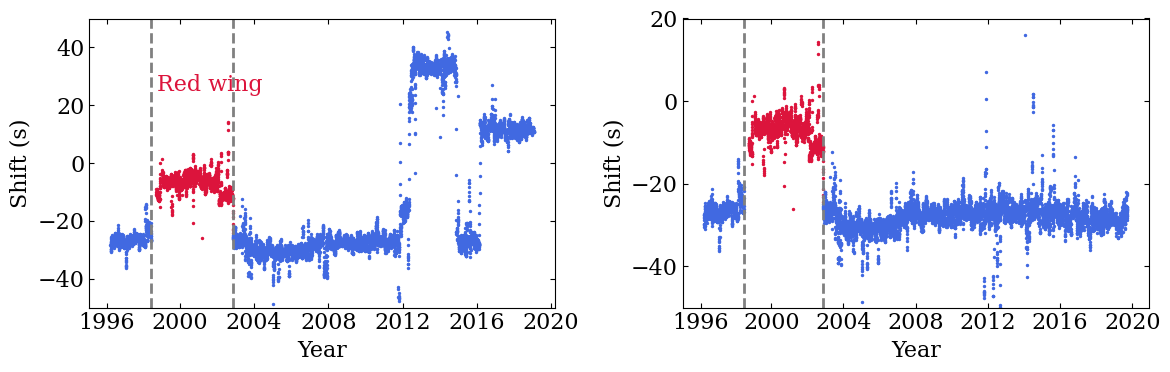

In [12]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(12,4))
all_ticks = False

# Point size on the plot
s = (144./fig.dpi)**2

#removing "SoHO vacations" on the plot
shifts[np.abs(shifts)<1e-5] = np.nan
shifts_uncorrected[np.abs(shifts_uncorrected)<1e-5] = np.nan

ax1.scatter (stamps_uncorrected[cond_2], shifts_uncorrected[cond_2]*60., marker='o', s=s, color='crimson')
ax2.scatter (stamps[cond_1], shifts[cond_1]*60., marker='o', s=s, color='crimson')
ax1.scatter (stamps_uncorrected[~cond_2], shifts_uncorrected[~cond_2]*60., marker='o', s=s, color='royalblue')
ax2.scatter (stamps[~cond_1], shifts[~cond_1]*60., marker='o', s=s, color='royalblue')

ax1.axvline (805, ls='--', lw=2, color='grey')
ax2.axvline (805, ls='--', lw=2, color='grey')
ax1.axvline (2412, ls='--', lw=2, color='grey')
ax2.axvline (2412, ls='--', lw=2, color='grey')

if all_ticks :
    ticks = [-71, 629, 1359, 2090, 2820, 3551, 4281, 5012, 5742, 6473, 7203, 7931, 8661]
    ticklabels ([1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020])
else :
    ticks = [-71, 1359, 2820, 4281, 5742, 7203, 8661]
    ticklabels = [1996, 2000, 2004, 2008, 2012, 2016, 2020]

for ax in (ax1, ax2) :
    ax.set_xticks (ticks)
    ax.set_xticklabels (ticklabels)
    ax.set_ylabel ('Shift (s)')
    ax.set_xlabel ('Year')

ax1.text (920, 25, 'Red wing', color='crimson')
ax1.set_ylim (-50, 50)
ax2.set_ylim (-50, 20)

fig.tight_layout ()

plt.savefig ('golf_shift.png', dpi=250)

In [ ]:
# Red wing: 25 June 1998
# Blue wing restarted: 18 November 2002